对于RAG来说，处理半结构化数据具有挑战性，因为：

- 文本拆分可能会破坏表格
- 表格和图像对于嵌入和语义搜索都具有挑战性

典型的半结构化数据是包含文本、表格、图像等内容的PDF文档。


下面使用以下组件来演示如何在半结构化数据上构建RAG：

✂️ unstructured

🦜 LangChain

🗂 Chromadb

准备环境

``` shell
$ pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken
```

安装两个必要的系统包

``` shell
$ apt-get install poppler-utils tesseract-ocr
```

下载PDF文件

``` shell
$ wget -O statement_of_changes.pdf https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/381953f9-934e-4cc8-b099-144910676bad.pdf
```

准备一个OPENAI_API_KEY

``` python
import os
os.environ["OPENAI_API_KEY"] = "Your Valid OpenAI API Key"
```

In [ ]:
!pip install langchain unstructured[all-docs] pydantic lxml openai chromadb tiktoken

In [ ]:
!apt-get install poppler-utils tesseract-ocr

In [ ]:
!wget -O statement_of_changes.pdf https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/381953f9-934e-4cc8-b099-144910676bad.pdf

--2023-11-21 03:01:55--  https://d18rn0p25nwr6d.cloudfront.net/CIK-0001045810/381953f9-934e-4cc8-b099-144910676bad.pdf
Resolving d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)... 99.86.37.225, 99.86.37.70, 99.86.37.153, ...
Connecting to d18rn0p25nwr6d.cloudfront.net (d18rn0p25nwr6d.cloudfront.net)|99.86.37.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119037 (116K) [application/pdf]
Saving to: ‘statement_of_changes.pdf’

statement_of_change 100%[===================>] 116.25K  --.-KB/s    in 0.02s   

2023-11-21 03:01:55 (6.39 MB/s) - ‘statement_of_changes.pdf’ saved [119037/119037]



In [7]:
# file 2
!wget -O IF10244.pdf https://sgp.fas.org/crs/misc/IF10244.pdf

--2023-11-21 05:08:54--  https://sgp.fas.org/crs/misc/IF10244.pdf
Resolving sgp.fas.org (sgp.fas.org)... 44.235.49.251
Connecting to sgp.fas.org (sgp.fas.org)|44.235.49.251|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 435826 (426K) [application/pdf]
Saving to: ‘IF10244.pdf’

IF10244.pdf         100%[===================>] 425.61K  --.-KB/s    in 0.08s   

2023-11-21 05:08:54 (5.11 MB/s) - ‘IF10244.pdf’ saved [435826/435826]



### 使用Unstructured 对pdf文件进行拆分

In [8]:
from typing import Any
from pydantic import BaseModel
from unstructured.partition.pdf import partition_pdf
from langchain.chat_models import ChatOpenAI
from langchain.prompts import ChatPromptTemplate
from langchain.schema.output_parser import StrOutputParser

raw_pdf_elements = partition_pdf(
    filename="IF10244.pdf",
    extract_images_in_pdf=True,
    infer_table_structure=True,
    chunking_strategy="by_title",
    max_characters=4000,
    new_after_n_chars=3800,
    combine_text_under_n_chars=2000,
    image_output_dir_path=".",
)

class Element(BaseModel):
    type: str
    text: Any

table_elements = []
text_elements = []
for element in raw_pdf_elements:
    if "unstructured.documents.elements.Table" in str(type(element)):
        table_elements.append(Element(type="table", text=str(element)))
    elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
        text_elements.append(Element(type="text", text=str(element)))

In [15]:
text_elements

[Element(type='text', text='a. aa = Informing the legislative debate since 1914 Congressional Research Service\n\nUpdated June 1, 2023\n\nWildfire Statistics\n\nWildfires are unplanned fires, including lightning-caused fires, unauthorized human-caused fires, and escaped fires from prescribed burn projects. States are responsible for responding to wildfires that begin on nonfederal (state, local, and private) lands, except for lands protected by federal agencies under cooperative agreements. The federal government is responsible for responding to wildfires that begin on federal lands. The Forest Service (FS)—within the U.S. Department of Agriculture—carries out wildfire management and response across the 193 million acres of the National Forest System (NFS). The Department of the Interior (DOI) manages wildfire response for more than 400 million acres of national parks, wildlife refuges and preserves, other public lands, and Indian reservations.\n\nFigure 1. Annual Wildfires and Acres B

In [10]:
table_elements

[Element(type='table', text='2018 2019 2020 2021 2022 Number of Fires (thousands) Federal 12.5 10.9 14.4 14.0 11.7 FS 5.6 5.3 6.7 6.2 5.9 DOI 7.0 5.3 7.6 7.6 5.8 Other 0.1 0.2 <0.1 0.2 0.1 Nonfederal 45.6 39.6 44.6 45.0 57.2 Total 58.1 50.5 59.0 59.0 69.0 Acres Burned (millions) Federal 4.6 3.1 7.1 5.2 4.0 FS 2.3 0.6 4.8 4.1 1.9 DOI 2.3 2.3 2.3 1.0 2.1 Other <0.1 <0.1 <0.1 <0.1 <0.1 Nonfederal 4.1 1.6 3.1 1.9 3.6 Total 8.8 4.7 10.1 7.1 7.6'),
 Element(type='table', text='2019 2020 2021 2022 Structures Burned 963 17,904 5,972 2,717 % Residences 46% 54% 60% 46%')]

Image figure-1-3.jpg



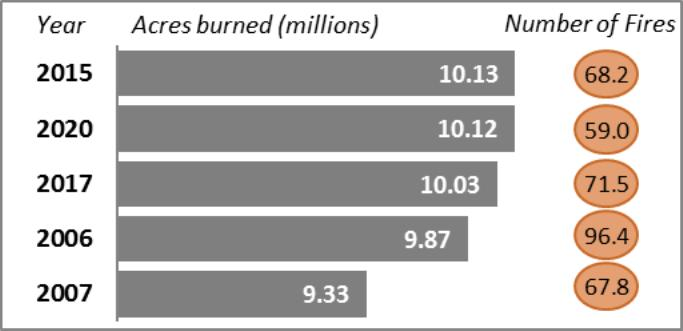

Image figure-2-2.jpg



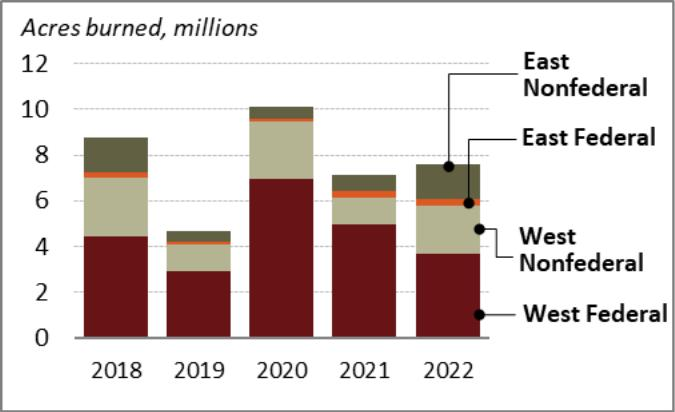

Image figure-2-1.jpg



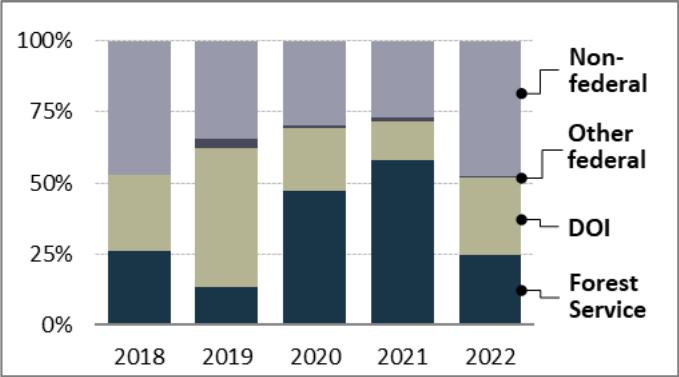

Image figure-1-2.jpg



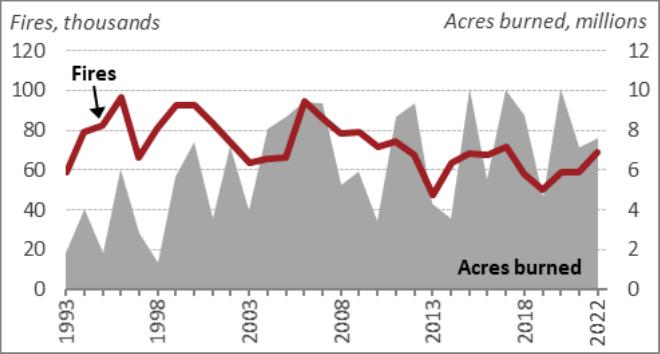

Image figure-1-1.jpg



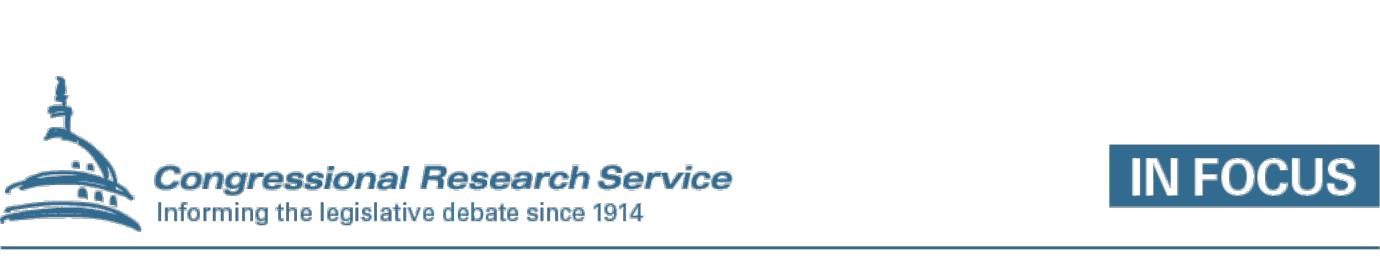

In [14]:
# images_elements
import os
from IPython.display import Image, display

# List all files in the current directory and filter for .jpg images
image_files = [f for f in os.listdir('.') if f.endswith('.jpg')]

# Display each image
for image_file in image_files:
  print(f"Image {image_file}\n")
  display(Image(filename=image_file))

### 构建LangChain摘要链

对每个文本元素和表格元素的文本做摘要，并创建MultiVectorRetriever。该检索器基于每个元素的摘要，和原始文本分块，以提供更高质量的相关文档检索。

In [ ]:
prompt_text = """
  You are responsible for concisely summarizing table or text chunk:

  {element}
"""
prompt = ChatPromptTemplate.from_template(prompt_text)
summarize_chain = {"element": lambda x: x} | prompt | ChatOpenAI(temperature=0, model="gpt-3.5-turbo") | StrOutputParser()

tables = [i.text for i in table_elements]
table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

texts = [i.text for i in text_elements]
text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})

import uuid

from langchain.embeddings import OpenAIEmbeddings
from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.schema.document import Document
from langchain.storage import InMemoryStore
from langchain.vectorstores import Chroma

id_key = "doc_id"

# The retriever (empty to start)
retriever = MultiVectorRetriever(
    vectorstore=Chroma(collection_name="summaries", embedding_function=OpenAIEmbeddings()),
    docstore=InMemoryStore(),
    id_key=id_key,
)

# Add texts
doc_ids = [str(uuid.uuid4()) for _ in texts]
summary_texts = [
    Document(page_content=s, metadata={id_key: doc_ids[i]})
    for i, s in enumerate(text_summaries)
]
retriever.vectorstore.add_documents(summary_texts)
retriever.docstore.mset(list(zip(doc_ids, texts)))

# Add tables
table_ids = [str(uuid.uuid4()) for _ in tables]
summary_tables = [
    Document(page_content=s, metadata={id_key: table_ids[i]})
    for i, s in enumerate(table_summaries)
]
retriever.vectorstore.add_documents(summary_tables)
retriever.docstore.mset(list(zip(table_ids, tables)))

### 构建问答链，提问

In [ ]:
from langchain.schema.runnable import RunnablePassthrough

template = """Answer the question based only on the following context, which can include text and tables:
{context}
Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)

# RAG pipeline
chain = (
    {"context": retriever, "question": RunnablePassthrough()}
    | prompt
    | ChatOpenAI(temperature=0, model="gpt-4")
    | StrOutputParser()
)
chain.invoke("How many stocks were disposed? Who is the beneficial owner?")